In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the finetune performance

In [8]:
mask_ratios = range(10, 100, 10)
lrs = ["1e-4", "1e-5", "1e-6"]
transforms = ["instance_normalize", "normalize", "log"]
targets = ["CaCO3", "TOC"]

rows = []

for mask_ratio in mask_ratios:
    for lr in lrs:
        for t in transforms:
            for target in targets:
                try:
                    with open(f"../results/finetune_pretrained/pretrain-mask-ratio-{mask_ratio/100}-blr-{lr}-transform-{t}/{target}/{target}.txt") as f:
                        words = f.readline().split()
                        r_square = float(words[-1])
                        rows.append([mask_ratio/100, float(lr), t, target, r_square])
                except FileNotFoundError:
                    pass
df = pd.DataFrame(rows, columns=["mask_ratio", "lr", "transform", "target", "r_square"])
print(df.head())
print(df.shape)
#df.to_csv("../finetune_pretrained.csv")

   mask_ratio      lr           transform target  r_square
0         0.1  0.0001  instance_normalize  CaCO3     0.976
1         0.1  0.0001  instance_normalize    TOC     0.950
2         0.1  0.0001           normalize  CaCO3     0.956
3         0.1  0.0001           normalize    TOC     0.957
4         0.1  0.0001                 log  CaCO3     0.960
(162, 5)


In [4]:
# Use the following line to read the compiled r2 file
df = pd.read_csv("../finetune_pretrained.csv", index_col=0)

# Plot the optimal model's $R^{2}$ in each mask ratio
Basically, I don't want to discuss lr so I simply take the optimal model in each mask ratio or transform. There are three methods to get the optimal model:

## Method 1
1-1 First seperate CaCO3 and TOC, then seperate three different transform, take the optimal model's $R^{2}$ value in different mask ratio and plot them.

1-2 Based on these $R^{2}$ values, average the best $R^{2}$ value of CaCO3 and TOC in each mask ratio and plot them. In this way, we may average two different pre-trained models' performance.

                 lr           transform target  r_square
mask_ratio                                              
0.1         0.00010  instance_normalize  CaCO3     0.976
0.2         0.00010  instance_normalize  CaCO3     0.979
0.3         0.00010  instance_normalize  CaCO3     0.974
0.4         0.00010  instance_normalize  CaCO3     0.972
0.5         0.00010  instance_normalize  CaCO3     0.976
0.6         0.00010  instance_normalize  CaCO3     0.982
0.7         0.00010  instance_normalize  CaCO3     0.979
0.8         0.00010  instance_normalize  CaCO3     0.973
0.9         0.00001  instance_normalize  CaCO3     0.973
                 lr  transform target  r_square
mask_ratio                                     
0.1         0.00001  normalize  CaCO3     0.974
0.2         0.00001  normalize  CaCO3     0.970
0.3         0.00001  normalize  CaCO3     0.972
0.4         0.00001  normalize  CaCO3     0.966
0.5         0.00001  normalize  CaCO3     0.970
0.6         0.00010  normalize  CaCO3

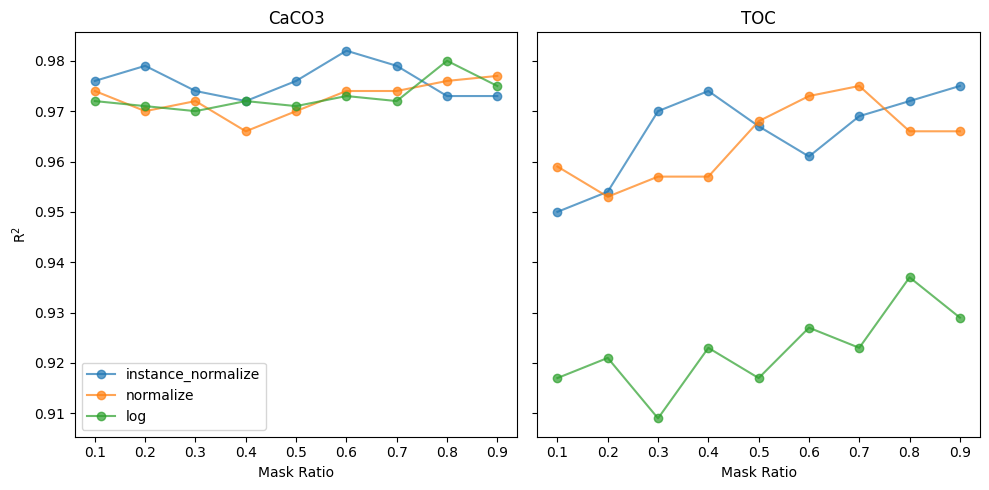

In [23]:
# 1-1 plot
# This one I even don't care lr.
fig, axes = plt.subplots(1, 2, sharey="row", figsize=(10, 5))

for ax, target in zip(axes, targets):
    for t in transforms:
        mask = (df["transform"] == t) & (df["target"] == target)
        best_r2_df = df[mask].groupby("mask_ratio").apply(lambda x: x.loc[x["r_square"].idxmax()], include_groups=False).copy()
        ax.plot(best_r2_df.index, best_r2_df["r_square"], label=t, marker="o", alpha=0.7)
        ax.set_title(target)
        print(best_r2_df)

    ax.set_xlabel("Mask Ratio")

axes[0].legend()
axes[0].set_ylabel("R$^2$")
plt.tight_layout()

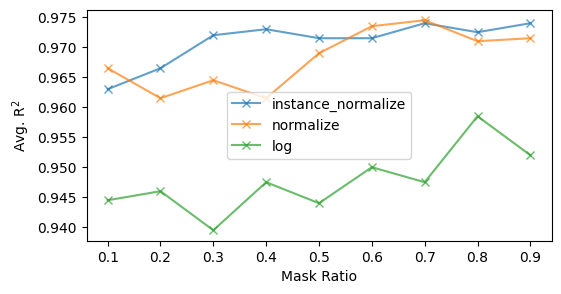

In [21]:
# 1-2 plot
# This one I even don't care lr and transform.
plt.figure(figsize=(6, 3))

r2_df = pd.DataFrame()
for t in transforms:
    tmp_df = pd.DataFrame()
    for target in targets:
        mask = (df["transform"] == t) & (df["target"] == target)
        tmp_df[target]= df[mask].groupby("mask_ratio").apply(lambda x: x["r_square"].max(), include_groups=False).copy()
    r2_mean = tmp_df.mean(axis=1)
    plt.plot(r2_mean.index, r2_mean, label=t, marker="x", alpha=0.7)

plt.xlabel("Mask Ratio")
plt.ylabel("Avg. R$^2$")
plt.legend()

In [16]:
max_idx = []
max_idx.append(df.loc[(df["transform"] == "normalize") & (df["mask_ratio"] == 0.7) & (df.target == "CaCO3"), "r_square"].idxmax())
max_idx.append(df.loc[(df["transform"] == "normalize") & (df["mask_ratio"] == 0.7) & (df.target == "TOC"), "r_square"].idxmax())
print(df.loc[max_idx])

     mask_ratio       lr  transform target  r_square
116         0.7  0.00001  normalize  CaCO3     0.974
111         0.7  0.00010  normalize    TOC     0.975


As a result, we then take the model pre-trained with 0.7 mask ratio and normalize as the optimal model. But we don't know which lr setting the optimal model pre-trained from. If we look into the models pretrained by 0.7 mask ratio and normalize transform, we find two models with different lr produce the best $R^{2}$ value for CaCO3 and TOC respectively.

## Method 2
2-1 First seperate CaCO3 and TOC, then take the optimal model's $R^{2}$ value in different mask ratio without taking care of transform.

2-2 Based on these $R^{2}$ values, average the best $R^{2}$ value of CaCO3 and TOC in each mask ratio and plot them. In this way, we may average two different pre-trained models' performance.

                lr           transform target  r_square
mask_ratio                                             
0.1         0.0001  instance_normalize  CaCO3     0.976
0.2         0.0001  instance_normalize  CaCO3     0.979
0.3         0.0001  instance_normalize  CaCO3     0.974
0.4         0.0001  instance_normalize  CaCO3     0.972
0.5         0.0001  instance_normalize  CaCO3     0.976
0.6         0.0001  instance_normalize  CaCO3     0.982
0.7         0.0001  instance_normalize  CaCO3     0.979
0.8         0.0001                 log  CaCO3     0.980
0.9         0.0001           normalize  CaCO3     0.977
                 lr           transform target  r_square
mask_ratio                                              
0.1         0.00001           normalize    TOC     0.959
0.2         0.00010  instance_normalize    TOC     0.954
0.3         0.00010  instance_normalize    TOC     0.970
0.4         0.00010  instance_normalize    TOC     0.974
0.5         0.00010           normalize   

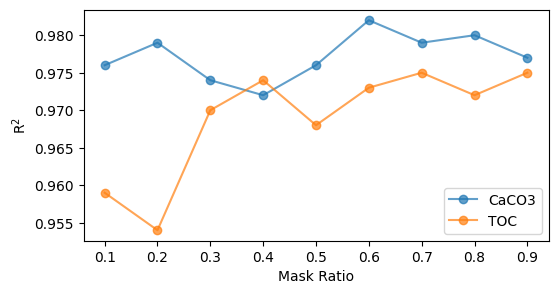

In [5]:
# 2-1 plot
# This one I even don't care lr and transform.
plt.figure(figsize=(6, 3))

for target in targets:
    best_r2_df = df[df["target"] == target].groupby("mask_ratio").apply(lambda x: x.loc[x["r_square"].idxmax()], include_groups=False).copy()
    print(best_r2_df)
    plt.plot(best_r2_df.index, best_r2_df["r_square"], label=target, marker="o", alpha=0.7)

plt.xlabel("Mask Ratio")
plt.ylabel("R$^2$")
plt.legend()

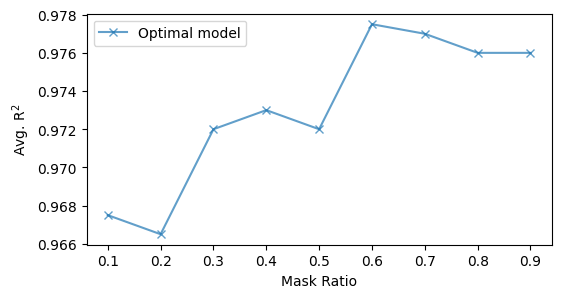

In [18]:
# 2-2 plot
# This one I even don't care lr and transform.
plt.figure(figsize=(6, 3))

r2_df = pd.DataFrame()
for target in targets:
    r2_df[target]= df[df["target"] == target].groupby("mask_ratio").apply(lambda x: x["r_square"].max(), include_groups=False).copy()

r2_mean =  r2_df.mean(axis=1)

plt.plot(r2_mean.index, r2_mean, label="Optimal model", marker="x", alpha=0.7)

plt.xlabel("Mask Ratio")
plt.ylabel("Avg. R$^2$")
plt.legend()

In [15]:
max_idx = []
max_idx.append(df.loc[(df.mask_ratio == 0.6) & (df.target == "CaCO3"), "r_square"].idxmax())
max_idx.append(df.loc[(df.mask_ratio == 0.6) & (df.target == "TOC"), "r_square"].idxmax())
print(df.loc[max_idx])

    mask_ratio      lr           transform target  r_square
90         0.6  0.0001  instance_normalize  CaCO3     0.982
93         0.6  0.0001           normalize    TOC     0.973


As a result, we then take the model pre-trained with 0.6 mask ratio as the optimal model. But we don't know which transform and lr settings the optimal model pre-trained from. If we look into the models pretrained by 0.6 mask ratio, we find the model with instance_normalize and normalize transform produce the best $R^{2}$ value for CaCO3 and TOC, respectively. By coincidence, the lr is the same.

## Method 3
3-1 First average the $R^{2}$ values of CaCO3 and TOC produced by each pre-trained model, then separate three different transforms, take the best average $R^{2}$ value in each mask ratio and plot them. In this way, we avoid the averaging of two different pre-trained models' performance.

3-2 Based on these averaged $R^{2}$ values, I pick the optimal model in each mask ratio. 

In [3]:
r2_mean_df = pd.DataFrame()
for i in range(1, len(df), 2):
    r2_mean = df.loc[i:i+1, "r_square"].mean()
    tmp_df = df.iloc[i, :3].copy()
    tmp_df["r2_mean"] = r2_mean
    r2_mean_df = pd.concat([r2_mean_df, tmp_df], axis=1)

r2_mean_df = r2_mean_df.T.reset_index(drop=True)
r2_mean_df

,mask_ratio,lr,transform,r2_mean
0,0.1,0.0001,instance_normalize,0.953
1,0.1,0.0001,normalize,0.9585
2,0.1,0.0001,log,0.923
3,0.1,0.00001,instance_normalize,0.956
4,0.1,0.00001,normalize,0.9655
...,...,...,...,...
76,0.9,0.00001,normalize,0.9685
77,0.9,0.00001,log,0.9465
78,0.9,0.000001,instance_normalize,0.9125
79,0.9,0.000001,normalize,0.929


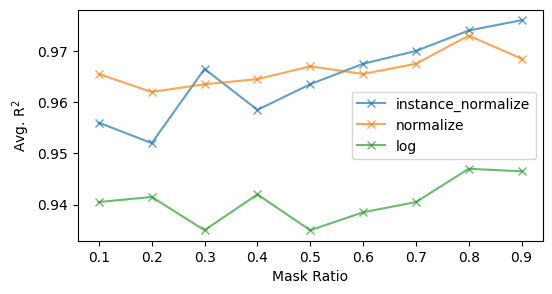

In [48]:
# 3-1 plot
# This one ignores lr
plt.figure(figsize=(6, 3))

for t in transforms:
    mask = r2_mean_df["transform"] == t
    r2_mean_ratios = r2_mean_df[mask].groupby("mask_ratio").apply(lambda x: x["r2_mean"].max(), include_groups=False).copy()
    plt.plot(r2_mean_ratios.index, r2_mean_ratios, label=t, marker="x", alpha=0.7)

plt.xlabel("Mask Ratio")
plt.ylabel("Avg. R$^2$")
plt.legend()

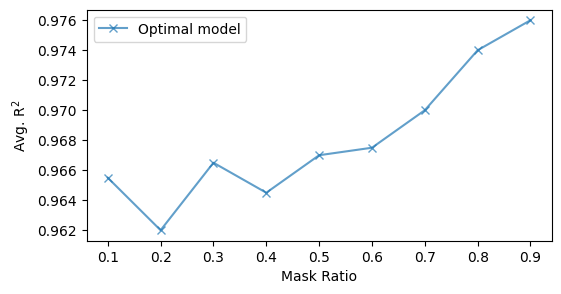

In [5]:
# 3-2 plot
# This one I don't care lr and transform
plt.figure(figsize=(6, 3))

r2_mean_ratios = r2_mean_df.groupby("mask_ratio").apply(lambda x: x["r2_mean"].max(), include_groups=False).copy()
plt.plot(r2_mean_ratios.index, r2_mean_ratios, label="Optimal model", marker="x", alpha=0.7)

plt.xlabel("Mask Ratio")
plt.ylabel("Avg. R$^2$")
plt.legend()

In [7]:
r2_mean_df.loc[r2_mean_df["r2_mean"].idxmax()]

mask_ratio                   0.9
lr                        0.0001
transform     instance_normalize
r2_mean                    0.976
Name: 72, dtype: object

As a result, we are able to simply take the model pre-trained with 0.9 mask ratio, instance_normalize transform and 0.0001 lr as the optimal model for fine-tuning.

## Conclusion
I choose the third method to get the optimal model since it is more straightforward in logic and to get the optimal model.